In [86]:
import pandas as pd
import numpy as np
import re
from datasets import Dataset, load_metric
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding


In [87]:
# read in our cleaned tweet from the model_serving notebook
tweets = pd.read_csv('../data/cleaned_tweets.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

tweets.head()

/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13-04-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14-04-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '25-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: User

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label
date,,,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...,2
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1,Malwarebytes rounded up some useful tips for s...,2
2020-01-04,29317,74269,Australia,01-04-2020,A Queensland mum has posted a heartbreaking pi...,Extremely Negative,1,A Queensland mum has posted a heartbreaking pi...,0
2020-01-04,29318,74270,Debt Jubilee,01-04-2020,New President Trump says U S gasoline prices w...,Neutral,1,New President Trump says U S gasoline prices w...,1
2020-01-04,29319,74271,??to Miami,01-04-2020,SUPERMARKET SAFETY is the latest grocery chain...,Extremely Positive,1,SUPERMARKET SAFETY is the latest grocery chain...,2


In [123]:
# Calculate accuracy change by month
monthly_stats = tweets.groupby('month')[['text']].count()
monthly_stats


,text
month,
1,220
2,359
3,1578
4,879
5,388
6,607
7,636
8,670
9,512


In [124]:
import torchdrift
import torch
from torch.utils.data import DataLoader
import tqdm
from nlp import Dataset
from transformers import AutoModelForSequenceClassification

# I have already trained a model using ONLY tweets up through March

In [90]:
class CovidExtractor(torch.nn.Module):
    def __init__(self):
        super(CovidExtractor, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained('./drift_clf/results', num_labels=3)

    def forward(self, _input):
        return(self.model.distilbert(**_input)).last_hidden_state[:,0,:]

In [91]:
covid_extractor = CovidExtractor()

loading configuration file ./drift_clf/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "./drift_clf/results",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "vocab_size": 30522
}

loading weights file ./drift_clf/results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassifi

In [92]:
# Kolmogorov-Smirnov test
detector = torchdrift.detectors.ks.KSDriftDetector()

In [104]:
detectors = {
    'ks': torchdrift.detectors.ks.KSDriftDetector(),
    'kernel': torchdrift.detectors.KernelMMDDriftDetector()
}

In [93]:
training_tweets = tweets[:'2020-03'].reset_index()
training_tweets.tail()


,date,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label
2152,2020-03-31,29063,74015,"Toronto, Canada",31-03-2020,Saputo says demand for its products is shiftin...,Negative,3,Saputo says demand for its products is shiftin...,0
2153,2020-03-31,28994,73946,"has passport, will travel",31-03-2020,Covid 19 - milk supply under threat amid deman...,Negative,3,Covid 19 - milk supply under threat amid deman...,0
2154,2020-03-31,29204,74156,"Walhalla, South Carolina",31-03-2020,Our latest details how fraudsters are trying t...,Negative,3,Our latest details how fraudsters are trying t...,0
2155,2020-03-31,29187,74139,"Arlington, VA",31-03-2020,Some consumer companies tap nearly 99B amid bo...,Neutral,3,Some consumer companies tap nearly 99B amid bo...,1
2156,2020-03-31,29276,74228,"Geneva, Switzerland",31-03-2020,EuropeÃÂs fresh food supply is being threate...,Negative,3,EuropeÃÂs fresh food supply is being threate...,0


In [94]:
march = Dataset.from_pandas(training_tweets[['text', 'label']])

march = march.map(preprocess, batched=True)

march.set_format('torch', columns=['input_ids', 'attention_mask'])

dl = DataLoader(march, batch_size=128, collate_fn=DataCollatorWithPadding(bert_tokenizer), shuffle=True)

nb = len(dl)

  0%|          | 0/3 [00:00<?, ?it/s]

In [95]:
all_outputs = []

for i, b in tqdm.tqdm(zip(range(nb), dl), total=nb):
    with torch.no_grad():
        all_outputs.append(covid_extractor(b))

all_outputs = torch.cat(all_outputs, dim=0)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:12<00:00, 14.83s/it]


In [96]:
detector.fit(all_outputs)

tensor([[ 0.0367,  0.3772, -0.1711,  ..., -0.9511,  0.7813, -1.3735],
        [-0.2789,  0.3597, -0.1800,  ..., -0.8356,  0.8592, -1.2687],
        [-0.2881, -0.2198,  0.6996,  ..., -0.4381, -0.0300,  0.5761],
        ...,
        [-0.6927, -0.2247,  0.3207,  ..., -0.1674, -0.4576, -0.0406],
        [ 0.0155, -0.3382,  0.7343,  ..., -0.4943,  0.0105,  0.0503],
        [-0.8570,  0.2670, -0.1425,  ..., -1.0843,  0.9389, -1.1407]])

In [107]:
for name, detector in detectors.items():
    detector.fit(all_outputs)
    print(f'Fit the {name} detector')

Fit the ks detector
Fit the kernel detector


In [145]:
# create a data loader to batch data together
dl = DataLoader(march, batch_size=128, collate_fn=DataCollatorWithPadding(bert_tokenizer), shuffle=True)

In [146]:
scores, p_vals = [], []

# run drift detector against benign data (from the training set)
for i, b in tqdm.tqdm(zip(range(1), dl), total=1):
    features = covid_extractor(b)
    for name, detector in detectors.items():
        print(name)
        score = detector(features)
        p_val = detector.compute_p_value(features)
        scores.append(score)
        p_vals.append(p_val)
        print(sum(scores)/(i + 1), sum(p_vals)/(i + 1))

  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

ks
tensor(0.1527) 1.0
kernel


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.35s/it]

tensor(0.1604) tensor(1.5910)


In [141]:
def ks_scores_for_month(detector, month, num_samples=1, batch_size=128):
    ood = tweets.loc[f'2020-{month}'].reset_index()

    ood = Dataset.from_pandas(ood[['text', 'label']])

    ood = ood.map(preprocess, batched=True)

    ood.set_format('torch', columns=['input_ids', 'attention_mask'])

    ood_dl = DataLoader(ood, batch_size=batch_size, collate_fn=DataCollatorWithPadding(bert_tokenizer), shuffle=True)
    
    ood_scores, ood_p_vals = [], []
    
    nb = min(num_samples, len(ood_dl))

    for i, b in tqdm.tqdm(zip(range(nb), ood_dl), total=nb):
        features = covid_extractor(b)
        score = detector(features)
        p_val = detector.compute_p_value(features)
        ood_scores.append(score)
        ood_p_vals.append(p_val)

    return float(sum(ood_p_vals) / len(ood_p_vals))


In [142]:
for name, detector in detectors.items():
    monthly_stats[f'{name}_p_value'] = monthly_stats.index.map(
        lambda x: ks_scores_for_month(detectors[name], x)
    )

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.83s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.09s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.43s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.51s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.55s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.08s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.79s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.52s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.24s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.76s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.73s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.35s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.62s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.73s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.69s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.26s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.34s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.71s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.92s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.11s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.12s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.62s/it]


In [143]:
monthly_stats

,text,ks_p_value,kernel_p_value
month,,,
1,220,1.000000,0.289
2,359,0.082843,0.042
3,1578,1.000000,0.467
4,879,0.110039,0.013
5,388,0.013746,0.027
6,607,0.016915,0.176
7,636,0.023961,0.042
8,670,0.085433,0.094
9,512,0.000091,0.003


<AxesSubplot:title={'center':'Plotting Divergence'}, xlabel='month'>

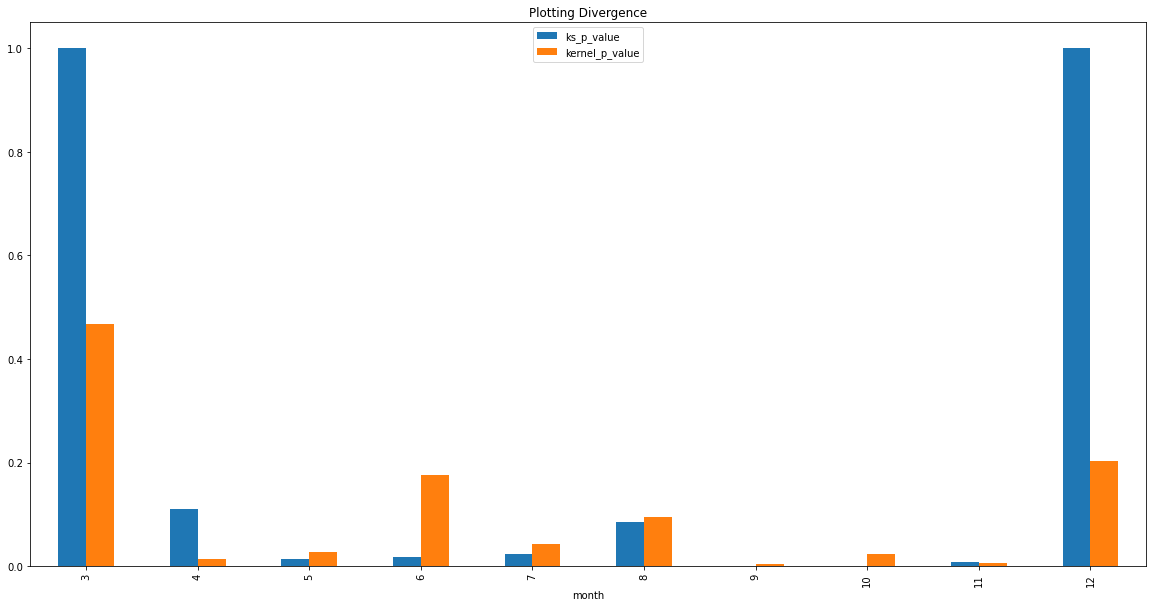

In [144]:
monthly_stats[monthly_stats.index >= 3].filter(regex='p_value').plot(
    kind='bar', figsize=(20, 10), title='Plotting Divergence'
)

In [154]:
# months where avg p-value is < .05
monthly_stats[monthly_stats.filter(regex='p_value').mean(1) < .05]

,text,ks_p_value,kernel_p_value
month,,,
5,388,0.013746,0.027
7,636,0.023961,0.042
9,512,0.000091,0.003
10,376,0.000523,0.024
11,333,0.008720,0.006
